In [1]:
from fastai.vision import *

from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import PascalVOCMetric

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = Path('.')
df = pd.read_csv(data_dir / 'stage_2_train_labels.csv')
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [3]:
len(df)

30227

In [4]:
df = df[df['Target'] == 1]
df.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [5]:
len(df)

9555

In [6]:
img2bbox = collections.defaultdict(lambda : [[], []])
img2bbox['0004cfab-14fd-4e49-80ba-63a80b6bddd6.jpg']

[[], []]

In [7]:
for n, row in df.iterrows():
    pid = row['patientId']
    img_file = str(f'{pid}.jpg')
    bbox = [row['x'], row['y'], row['width'], row['height']]
    img2bbox[img_file][0].append(bbox)
    img2bbox[img_file][1].append('pneumonia')
        
img2bbox['00436515-870c-4b36-a041-de91049b9ab4.jpg']

[[[264.0, 152.0, 213.0, 379.0], [562.0, 152.0, 256.0, 453.0]],
 ['pneumonia', 'pneumonia']]

In [8]:
get_y_func = lambda o:img2bbox[o.name]

In [9]:
size = 256
tfms = get_transforms()

data = ObjectItemList.from_folder(data_dir / 'train' / 'PNEUMONIA')
data = data.split_by_rand_pct().label_from_func(get_y_func).transform(tfms, tfm_y=True, size=size)
data = data.databunch(collate_fn=bb_pad_collate).normalize(imagenet_stats)

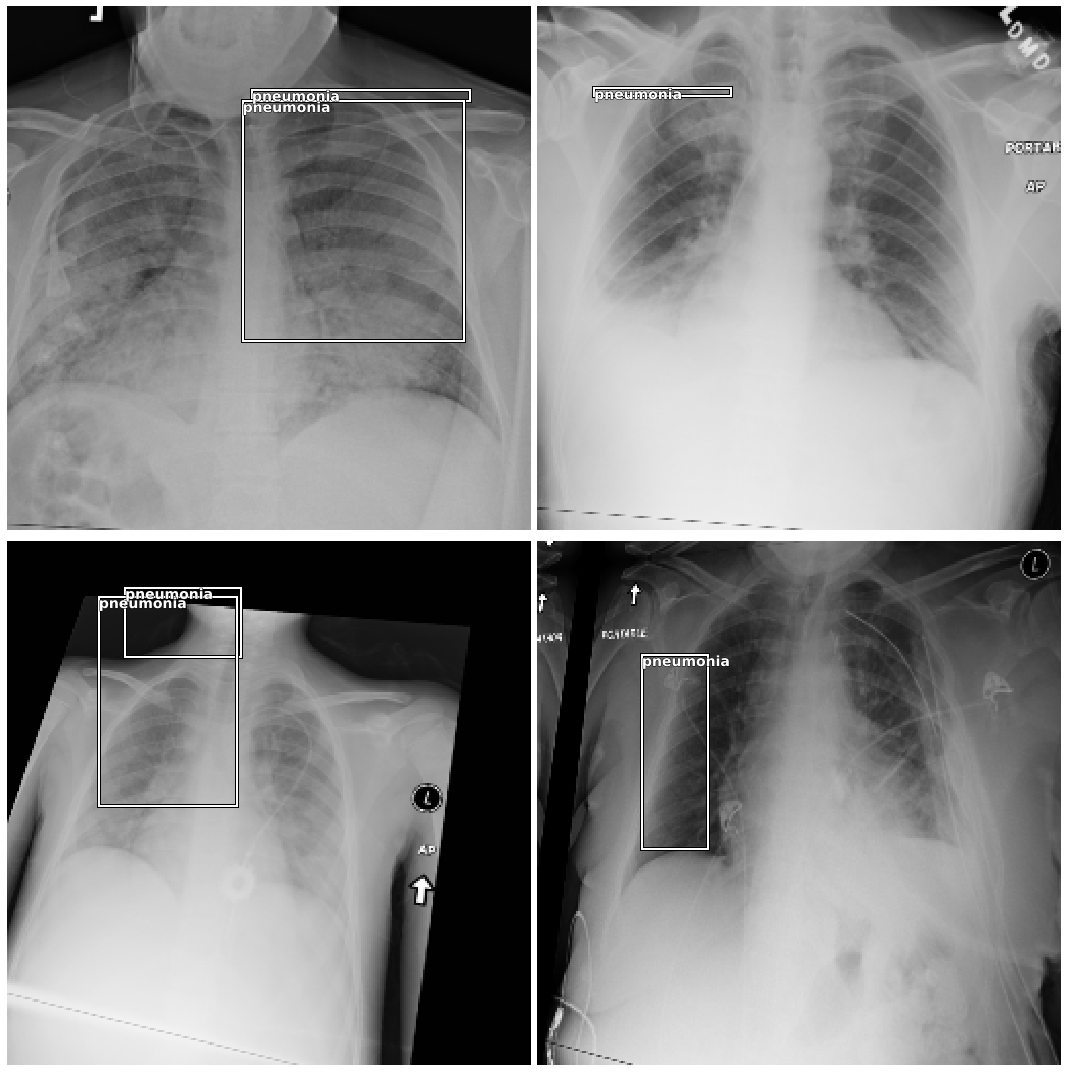

In [10]:
data.show_batch(rows=2, figsize=(15, 15))

In [11]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])

In [15]:
n_classes = data.train_ds.c

loss = RetinaNetFocalLoss(anchors)
encoder = create_body(models.resnet50, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)

epoch,train_loss,valid_loss,time
0,8.655518,#na#,00:56


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 2.09E-04


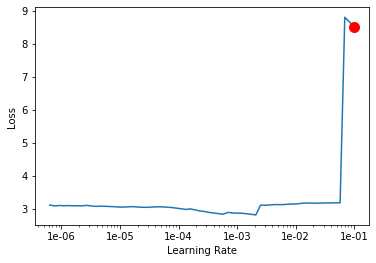

In [16]:
learn = Learner(data, model, loss_func=loss)

learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

learn.lr_find()
learn.recorder.plot(suggestion = True)

In [17]:
learn.fit_one_cycle(5, max_lr = 1e-3)

epoch,train_loss,valid_loss,time
0,2.094402,1.815235,01:06
1,1.879048,1.603245,01:06
2,1.688680,1.568690,01:06
3,1.566978,1.455573,01:05
4,1.474213,1.462306,01:05


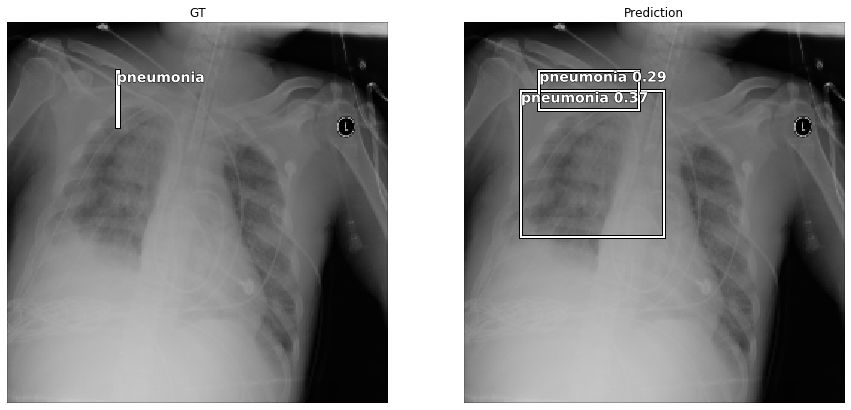

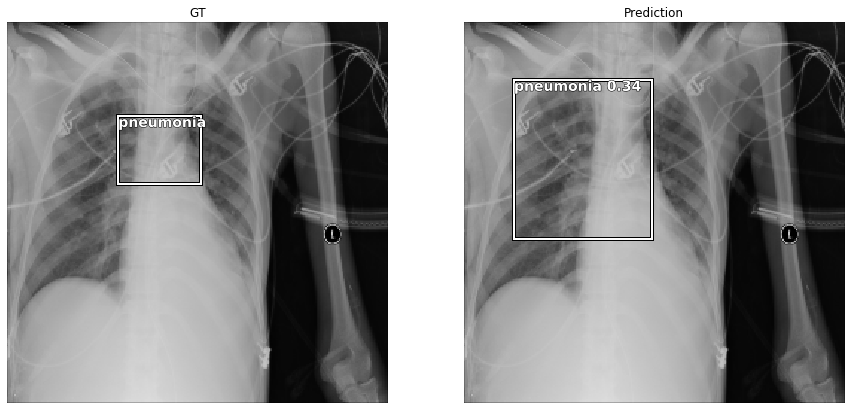

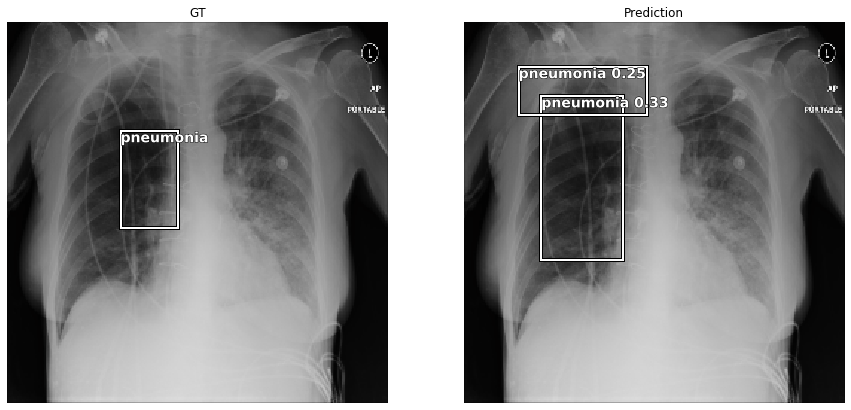

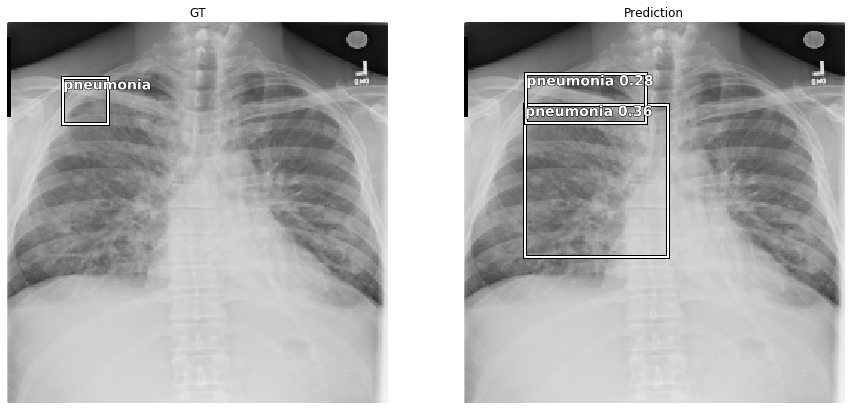

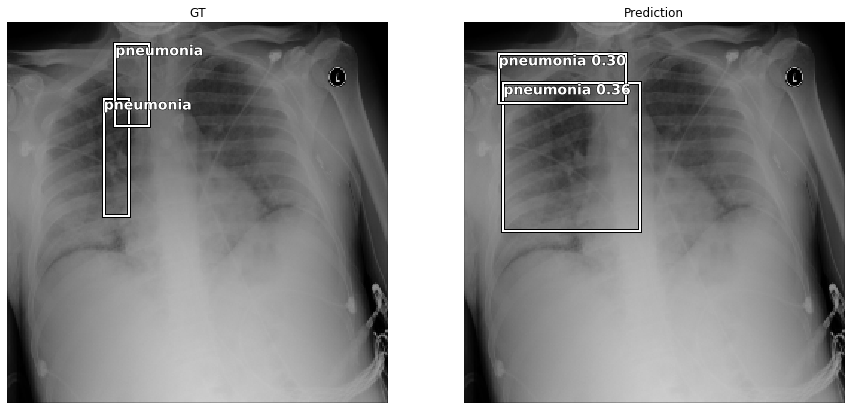

In [18]:
show_results_side_by_side(learn, anchors, detect_thresh=0.25, nms_thresh=0.1, image_count=5)

In [19]:
voc_map = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn.validate(metrics=[voc_map])

GT: 100%|██████████| 1672/1672 [00:00<00:00, 4915.40it/s]


[1.4623055, 0.210062588178216]

epoch,train_loss,valid_loss,time
0,3.189538,#na#,00:58


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-01
Min loss divided by 10: 6.31E-08


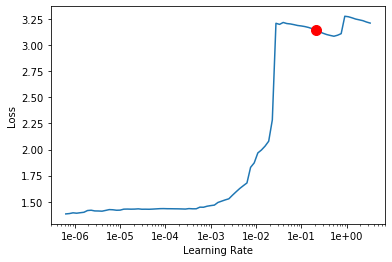

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [21]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 5e-04))

epoch,train_loss,valid_loss,time
0,1.435432,1.420883,01:08
1,1.467184,1.434218,01:08
2,1.436368,1.434596,01:09
3,1.405472,1.424433,01:09
4,1.386151,1.442271,01:09


In [22]:
learn.validate(metrics=[voc_map])

GT: 100%|██████████| 1612/1612 [00:00<00:00, 4337.13it/s]


[1.4422714, 0.2327251821249901]

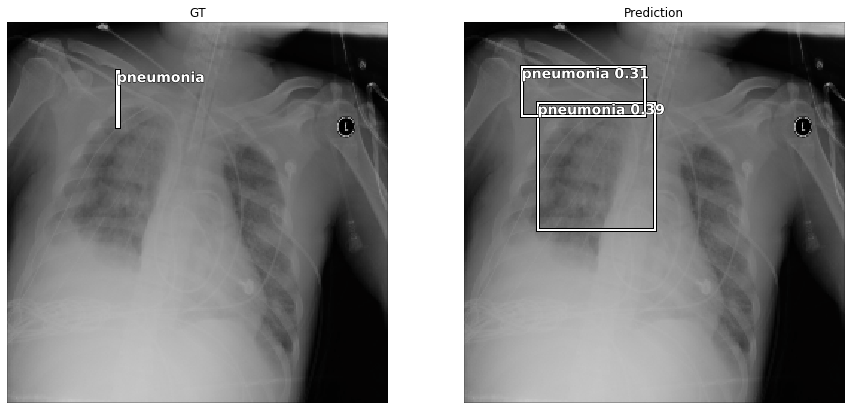

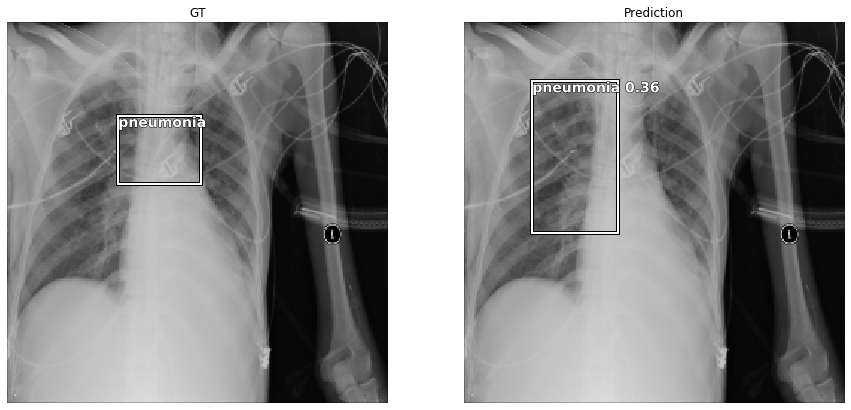

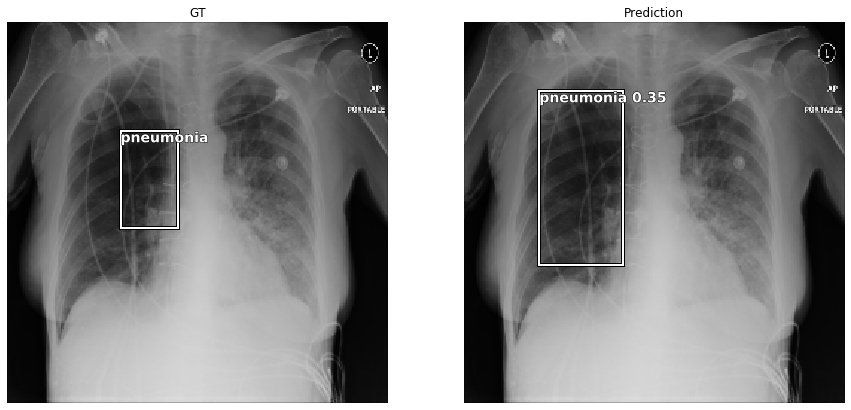

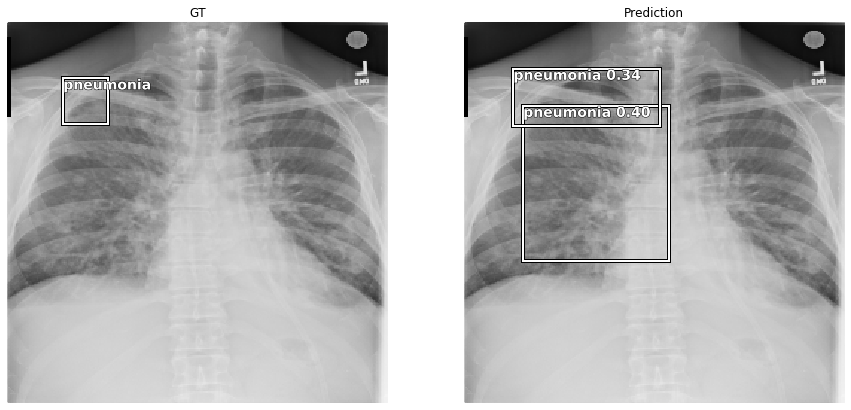

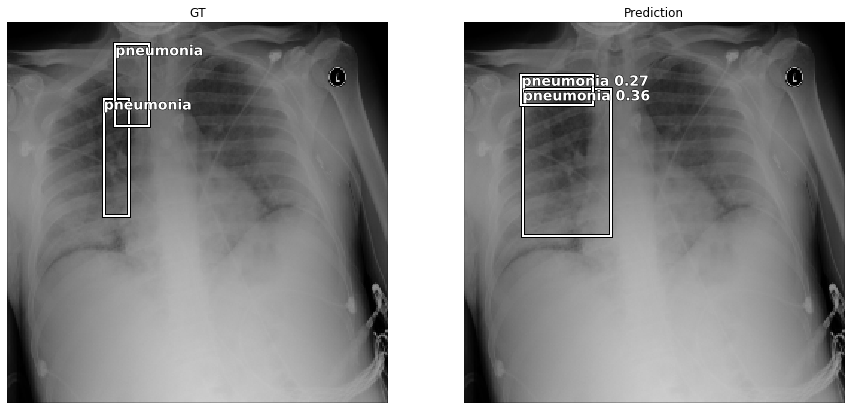

In [23]:
show_results_side_by_side(learn, anchors, detect_thresh=0.25, nms_thresh=0.1, image_count=5)